In [1]:
### Script for computing linear model parameter for GI subtype prediction
## Designed for the LOO training/testing strategy

import glob
import numpy as np
import torch
import scanpy as sc
import pandas as pd 
import copy
import sys
sys.path.append('../')
import os
from data import PertDataloader
from inference import evaluate, compute_metrics
from scipy.stats import pearsonr, spearmanr
from inference import GIs
import seaborn as sns
from fig_utils import *

# Linear model fitting functions
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from dcor import distance_correlation, partial_distance_correlation
from sklearn.metrics import r2_score

## Model inference functions

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import font_manager
font_dirs = ["/dfs/user/yhr/snap/perturb_GNN/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
#sns.set(rc={'figure.figsize':(6,6)})
#sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.5)
#plt.rc('axes', unicode_minus=False)

In [3]:
adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hi_umi+hvg.h5ad')
all_conditions = adata.obs['condition'].unique()

In [10]:
adata.var = adata.var.set_index('gene_name')

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['RP11-34P13.8', 'FO538757.2', 'SAMD11', 'NOC2L', 'ISG15']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [4]:
def add_bar_group(plot_df, x, combo, gene, ax, seen=2):
    x_g,y_g = combo.split('+')
    x_pert = get_ctrl_pert(x_g, all_conds=all_conditions)
    y_pert = get_ctrl_pert(y_g, all_conds=all_conditions)
    
    if seen == 2:
        n1 = plot_df.loc[x_pert, gene]
        n2 = plot_df.loc[y_pert, gene]
    elif seen == 1:
        n1 = plot_df.loc[x_pert,gene]
        n2 = plot_df.loc['Naive', gene]

    pred = plot_df.loc[combo + '_p', gene]
    true = plot_df.loc[combo, gene]

    if seen == 2:
        ax.bar(x+1, n1, edgecolor='black', 
                linewidth=1.5, hatch="\\\\", color='goldenrod')
        ax.bar(x+1, n2, bottom=n1, edgecolor='black', 
                linewidth=1.5, color='goldenrod', hatch='//')
        ax.bar(x+2, pred, edgecolor='black', 
            linewidth=1, color='firebrick')
    elif seen == 1:
        ax.bar(x+1, n1, edgecolor='black', 
                linewidth=1.5, hatch="\\\\", color='goldenrod')
        ax.bar(x+2, n2, edgecolor='black', 
                linewidth=1.5, color='goldenrod', hatch='//')
        ax.bar(x+3, pred, edgecolor='black', 
            linewidth=1, color='firebrick')
        
    ax.bar(x, true, edgecolor='black', 
            linewidth=1, color='gray')
    
def add_bar_group_err(plot_df, x, combo, gene, ax, seen=2, 
                      combo_CIs=0, single_CIs_1=0, single_CIs_2=0, 
                      gears_CIs=0):
    x_g,y_g = combo.split('+')
    x_pert = get_ctrl_pert(x_g, all_conds=all_conditions)
    y_pert = get_ctrl_pert(y_g, all_conds=all_conditions)
    
    if seen == 2:
        n1 = plot_df.loc[x_pert, gene]
        n2 = plot_df.loc[y_pert, gene]
    elif seen == 1:
        n1 = plot_df.loc[x_pert,gene]
        n2 = plot_df.loc['Naive', gene]

    pred = plot_df.loc[combo + '_p', gene]
    true = plot_df.loc[combo, gene]

    ax.bar(x+1, n1, edgecolor='black', 
            linewidth=1.5, hatch="\\\\", color='goldenrod')

    if n1>0:
        if n2>0:
            n_ = n1
        if n2<0:
            n_ = 0
    else:
        if n2>0:
            n_ = 0
        if n2<0:
            n_ = n1       
    ax.bar(x+1, n2, bottom=n_, edgecolor='black', 
            linewidth=1.5, color='goldenrod', hatch='//')
    ax.bar(x+2, pred, edgecolor='black', 
        linewidth=1, color='firebrick')
        
    ax.bar(x, true, edgecolor='black', 
            linewidth=1, color='gray')
    plt.errorbar(x=x, y=true, yerr=combo_CIs, 
                 color='black')
    if n1>0:
        if n2>0:
            y_ = n1+n2
        if n2<0:
            y_ = n1
    else:
        if n2<0:
            y_ = n1+n2
        if n2>0:
            y_ = n2
        
        
    plt.errorbar(x=x+1, y=y_, yerr=np.abs(single_CIs_1)+np.abs(single_CIs_2), 
             color='black')
    plt.errorbar(x=x+2, y=pred, yerr=gears_CIs, 
             color='black')
    
def add_bar_grouph(plot_df, x, combo, gene, ax, seen=2):
    x_g,y_g = combo.split('+')
    x_pert = get_ctrl_pert(x_g, all_conds=all_conditions)
    y_pert = get_ctrl_pert(y_g, all_conds=all_conditions)
    
    if seen == 2:
        n1 = plot_df.loc[x_pert, gene]
        n2 = plot_df.loc[y_pert, gene]
    elif seen == 1:
        n1 = plot_df.loc[x_pert,gene]
        n2 = plot_df.loc['Naive', gene]

    pred = plot_df.loc[combo + '_p', gene]
    true = plot_df.loc[combo, gene]

    if seen == 2:
        ax.barh(x+1, n1, edgecolor='black', 
                linewidth=1.5, hatch="\\\\", color='goldenrod')
        ax.barh(x+1, n2, left=n1, edgecolor='black', 
                linewidth=1.5, color='goldenrod', hatch='//')
        ax.barh(x+2, pred, edgecolor='black', 
            linewidth=1, color='firebrick')
    elif seen == 1:
        ax.barh(x+1, n1, edgecolor='black', 
                linewidth=1.5, hatch="\\\\", color='goldenrod')
        ax.barh(x+2, n2, edgecolor='black', 
                linewidth=1.5, color='goldenrod', hatch='//')
        ax.barh(x+3, pred, edgecolor='black', 
            linewidth=1, color='firebrick')
        
    ax.barh(x, true, edgecolor='black', 
            linewidth=1, color='gray')

In [5]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [6]:
import pandas as pd

In [137]:
# Read in dataframe for perturbation 
#plot_df = pd.read_csv(, index_col=0)

# Supplementary figure
fname = '../GI_gene_mse/dfs/synergy_dissimilar_pheno_crossgene_PTPN12+ZBTB25'
#fname = '../GI_gene_mse/dfs/redundant_crossgene_MAP2K3+MAP2K6'
#fname = '../GI_gene_mse/dfs/synergy_similar_pheno_crossgene_CBL+PTPN12'
#fname = '../GI_gene_mse/dfs/epistasis_crossgene_DUSP9+ETS2'
#fname = '../GI_gene_mse/dfs/neomorphic_crossgene_FOSB+PTPN12'
#fname = '../GI_gene_mse/dfs/suppressor_crossgene_CEBPE+CNN1'
#fname = '../GI_gene_mse/dfs/additive_crossgene_MAP2K3+ELMSAN1'

plot_df = pd.read_csv(fname, index_col=0)


#plot_df = pd.read_csv('../GI_gene_mse/dfs/ZBTB25_crossgene_unc_ZBTB25+PTPN12_mean_pert',index_col=0)
plot_df = plot_df.iloc[:,:10]
plot_df

,ALAS2,HBA1,HBA2,HIST1H1C,GYPB,SLC25A37,DYNLRB1,LGALS1,TUFM,PKM
condition,,,,,,,,,,
PTPN12+ZBTB25,0.986675,1.014015,0.505525,0.446702,0.890892,0.913503,-0.000139,-0.223654,-0.215412,-0.622323
PTPN12+ctrl,0.231112,0.309838,0.056540,0.314922,0.291873,0.318293,-0.121072,-0.173084,0.008902,-0.207396
ctrl+ZBTB25,0.271942,0.295198,0.067995,0.403745,0.333089,0.350697,-0.120721,-0.281844,0.002314,-0.201372
Naive,0.503054,0.605036,0.124535,0.718668,0.624961,0.668990,-0.241794,-0.454928,0.011216,-0.408768
PTPN12+ZBTB25_p,0.865164,0.798037,0.619440,0.268109,0.696391,0.724887,-0.023881,-0.164149,-0.228124,-0.342685


In [143]:
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def get_CI(pert, genes):
    control_vals = adata[adata.obs['condition']=='ctrl'][:,list(genes)].X.toarray()
    control_vec = control_vals.mean(0)
    pred_vals = adata[adata.obs['condition']==pert][:,list(genes)].X

    corrected_pred = pred_vals.toarray() - control_vec
    
    CIs = []
    for col in range(corrected_pred.shape[1]):
        CIs.append(mean_confidence_interval(corrected_pred[:,col]))
    return CIs

def get_CI_perts(genes, n=300):
    ## Take several samples of size 300 from the control distribution
    ## Determine the 95% CI for these samples, this would be equivalent to the CI for the GEARS prediction
    ## Since the only souce of randomness is the control distribution
    
    control_vals = []
    ctrl_adata = adata[adata.obs['condition']=='ctrl']
    for itr in range(100):
        idxs = np.random.choice(ctrl_adata.obs.index, n)
        control_vals.append(ctrl_adata[idxs,list(genes)].X.toarray().mean(0))
    
    CIs = []
    control_vals = np.array(control_vals)
    for col in range(control_vals.shape[1]):
        CIs.append(mean_confidence_interval(control_vals[:,col]))
    return CIs

def get_CI_preds(combo, GI_genes):
    pred_vals = []

    for name in glob.glob('../GI_gene_mse/dfs/synergy_dissimilar_pheno_crossgene_'+combo+'_rep?')[:3]:
        df = pd.read_csv(name, index_col=0).loc[:,GI_genes]
        pred_vals.append(df.loc[combo + '_p'].values)

    pred_vals = np.array(pred_vals)
    
    CIs = []
    for col in range(pred_vals.shape[1]):
        CIs.append(mean_confidence_interval(pred_vals[:,col]))
        
    return pred_vals.mean(0), CIs

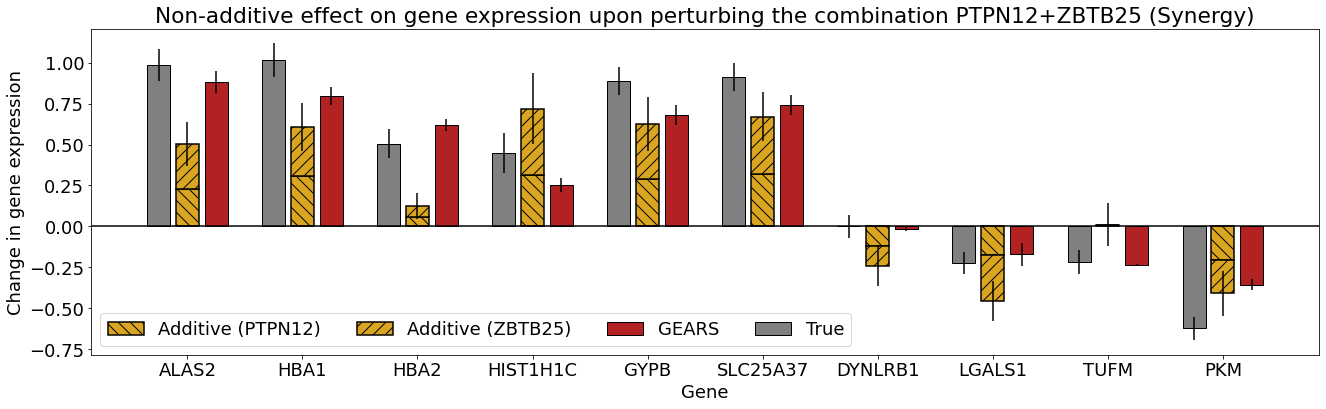

In [144]:
## With 95% CI

fig = plt.figure(figsize=[22,6])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
combo = fname.split('_')[-1]
g1 = combo.split('+')[0]
g2 = combo.split('+')[1]

label_map = {'synergy_similar_pheno': 'Synergy',
                 'synergy_dissimilar_pheno': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'additive':'Additivity',
                 'epistasis':'Epistasis'}
GI_type = label_map[fname.split('/')[-1].split('_crossgene')[0]]

genes = list(plot_df.columns)
combo_CIs = get_CI(combo, genes=genes)
single_CIs_1 = get_CI(get_single_name(g1, adata=adata), genes=genes)
single_CIs_2 = get_CI(get_single_name(g2, adata=adata), genes=genes)

# Get error bars for true values
GI_genes = ['ALAS2', 'HBA1', 'HBA2', 'HIST1H1C', 'GYPB', 'SLC25A37', 'DYNLRB1', 'LGALS1', 'TUFM', 'PKM']
get_CI_preds(combo, GI_genes)

# Get error bars for predictions
means, gears_CIs = get_CI_preds(combo, GI_genes)
# Update pred mean
plot_df = plot_df.T
plot_df[combo+'_p'] = means
plot_df = plot_df.T

# Old error bar code
#gears_CIs = get_CI_perts(genes=list(plot_df.columns))

for itr, gene in enumerate(plot_df.columns):
    add_bar_group_err(plot_df, (itr*step), combo, gene, ax, 
                      combo_CIs=combo_CIs[itr][1]-combo_CIs[itr][0],
                      single_CIs_1=single_CIs_1[itr][1] - single_CIs_1[itr][0],
                      single_CIs_2=single_CIs_2[itr][1] - single_CIs_2[itr][0],
                      gears_CIs = gears_CIs[itr][1] - gears_CIs[itr][0])
    xticks.append(itr*step+1)
    xticklabels.append(gene)

plt.legend(['Additive ({})'.format(g1), 'Additive ({})'.format(g2), 'GEARS', 'True'], 
          ncol=4, loc='lower left')

plt.ylabel('Change in gene expression')
#plt.ylim([-0.7, 1.1])
plt.xlabel('Gene')
plt.title('Non-additive effect on gene expression upon perturbing the combination '+combo + ' ({})'.format(GI_type) )

plt.xticks(xticks, xticklabels)

ax.axhline(y=0, color='k')

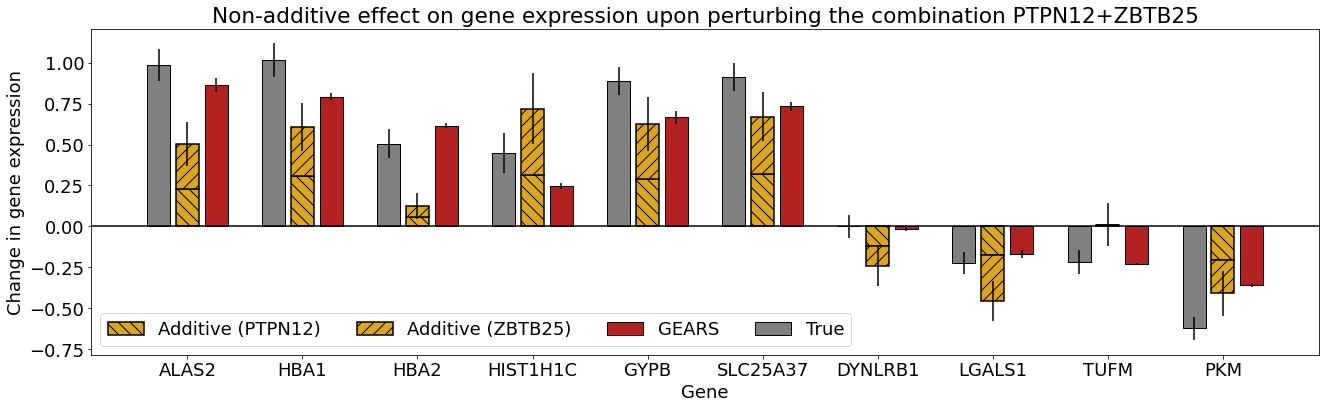

In [142]:
## With 95% CI

fig = plt.figure(figsize=[22,6])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
combo = fname.split('_')[-1]
g1 = combo.split('+')[0]
g2 = combo.split('+')[1]

label_map = {'synergy_similar_pheno': 'Synergy',
                 'synergy_dissimilar_pheno': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'additive':'Additivity',
                 'epistasis':'Epistasis'}
GI_type = label_map[fname.split('/')[-1].split('_crossgene')[0]]

genes = list(plot_df.columns)
combo_CIs = get_CI(combo, genes=genes)
single_CIs_1 = get_CI(get_single_name(g1, adata=adata), genes=genes)
single_CIs_2 = get_CI(get_single_name(g2, adata=adata), genes=genes)

# Get error bars for true values
GI_genes = ['ALAS2', 'HBA1', 'HBA2', 'HIST1H1C', 'GYPB', 'SLC25A37', 'DYNLRB1', 'LGALS1', 'TUFM', 'PKM']
get_CI_preds(combo, GI_genes)

# Get error bars for predictions
means, gears_CIs = get_CI_preds(combo, GI_genes)
# Update pred mean
plot_df = plot_df.T
plot_df[combo+'_p'] = means
plot_df = plot_df.T

# Old error bar code
#gears_CIs = get_CI_perts(genes=list(plot_df.columns))

for itr, gene in enumerate(plot_df.columns):
    add_bar_group_err(plot_df, (itr*step), combo, gene, ax, 
                      combo_CIs=combo_CIs[itr][1]-combo_CIs[itr][0],
                      single_CIs_1=single_CIs_1[itr][1] - single_CIs_1[itr][0],
                      single_CIs_2=single_CIs_2[itr][1] - single_CIs_2[itr][0],
                      gears_CIs = gears_CIs[itr][1] - gears_CIs[itr][0])
    xticks.append(itr*step+1)
    xticklabels.append(gene)

plt.legend(['Additive ({})'.format(g1), 'Additive ({})'.format(g2), 'GEARS', 'True'], 
          ncol=4, loc='lower left')

plt.ylabel('Change in gene expression')
#plt.ylim([-0.7, 1.1])
plt.xlabel('Gene')
plt.title('Non-additive effect on gene expression upon perturbing the combination '+combo + ' ({})'.format(GI_type) )

plt.xticks(xticks, xticklabels)

ax.axhline(y=0, color='k')

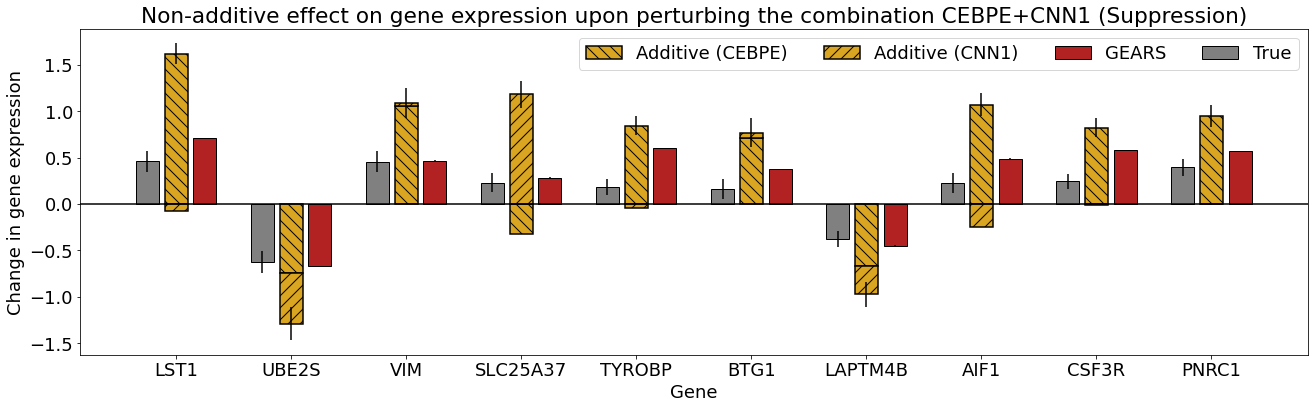

In [30]:
## With 95% CI

fig = plt.figure(figsize=[22,6])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
combo = fname.split('_')[-1]
g1 = combo.split('+')[0]
g2 = combo.split('+')[1]

label_map = {'synergy_similar_pheno': 'Synergy',
                 'synergy_dissimilar_pheno': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'additive':'Additivity',
                 'epistasis':'Epistasis'}
GI_type = label_map[fname.split('/')[-1].split('_crossgene')[0]]

genes = list(plot_df.columns)
combo_CIs = get_CI(combo, genes=genes)
single_CIs_1 = get_CI(get_single_name(g1, adata=adata), genes=genes)
single_CIs_2 = get_CI(get_single_name(g2, adata=adata), genes=genes)

# Get error bars for true values
GI_genes = ['ALAS2', 'HBA1', 'HBA2', 'HIST1H1C', 'GYPB', 'SLC25A37', 'DYNLRB1', 'LGALS1', 'TUFM', 'PKM']
get_CI_preds(combo, GI_genes)

# Get error bars for predictions
means, gears_CIs = get_CI_preds(combo, GI_genes)
# Update pred mean
plot_df = plot_df.T
plot_df[combo+'_p'] = means
plot_df = plot_df.T

gears_CIs = get_CI_perts(genes=list(plot_df.columns))

for itr, gene in enumerate(plot_df.columns):
    add_bar_group_err(plot_df, (itr*step), combo, gene, ax, 
                      combo_CIs=combo_CIs[itr][1]-combo_CIs[itr][0],
                      single_CIs_1=single_CIs_1[itr][1] - single_CIs_1[itr][0],
                      single_CIs_2=single_CIs_2[itr][1] - single_CIs_2[itr][0],
                      gears_CIs = gears_CIs[itr][1] - gears_CIs[itr][0])
    xticks.append(itr*step+1)
    xticklabels.append(gene)

plt.legend(['Additive ({})'.format(g1), 'Additive ({})'.format(g2), 'GEARS', 'True'], 
          ncol=4)

plt.ylabel('Change in gene expression')
#plt.ylim([-0.7, 1.1])
plt.xlabel('Gene')
plt.title('Non-additive effect on gene expression upon perturbing the combination '+combo + ' ({})'.format(GI_type) )

plt.xticks(xticks, xticklabels)

ax.axhline(y=0, color='k')

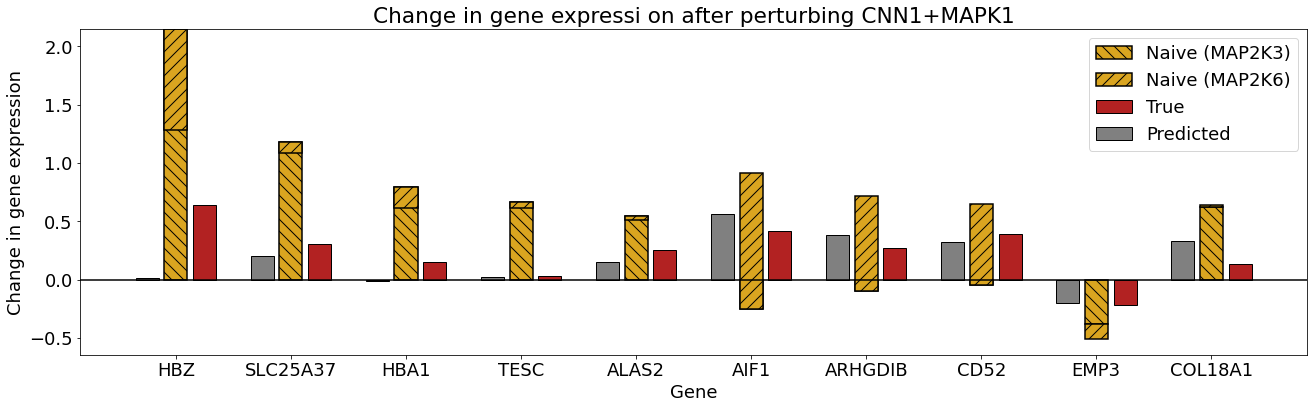

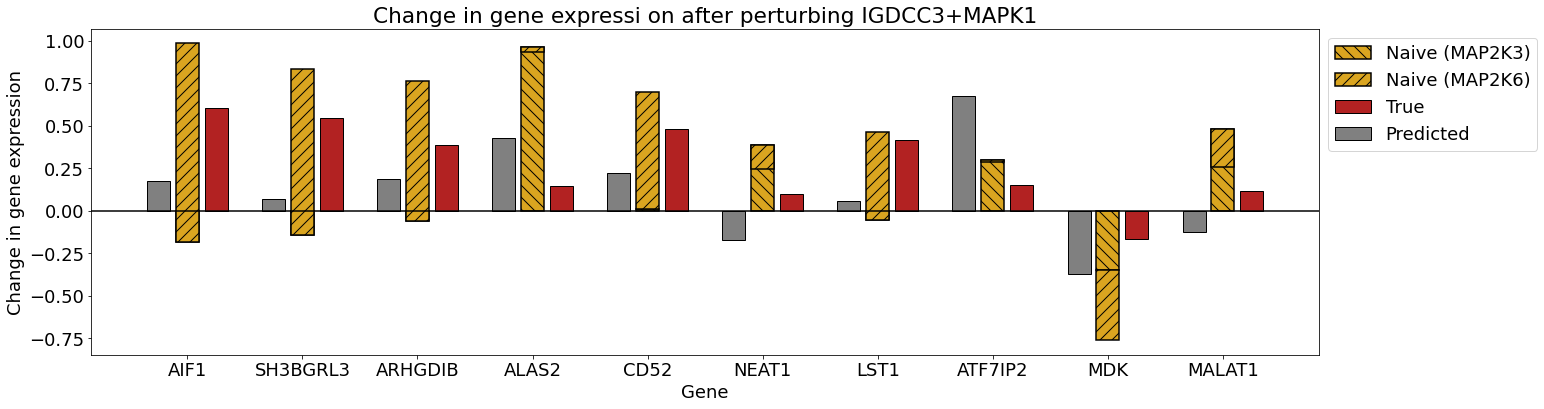

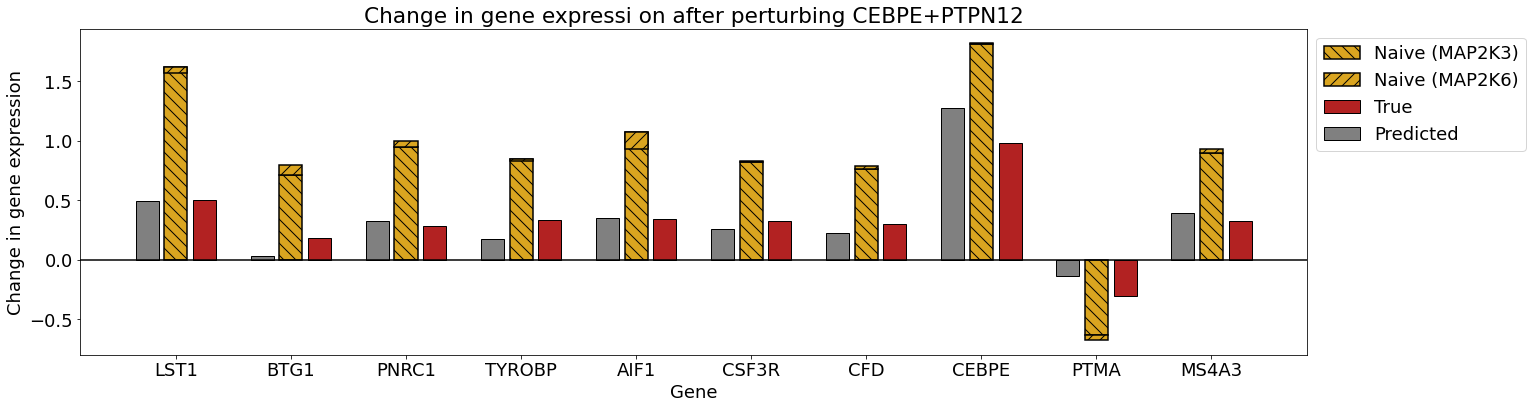

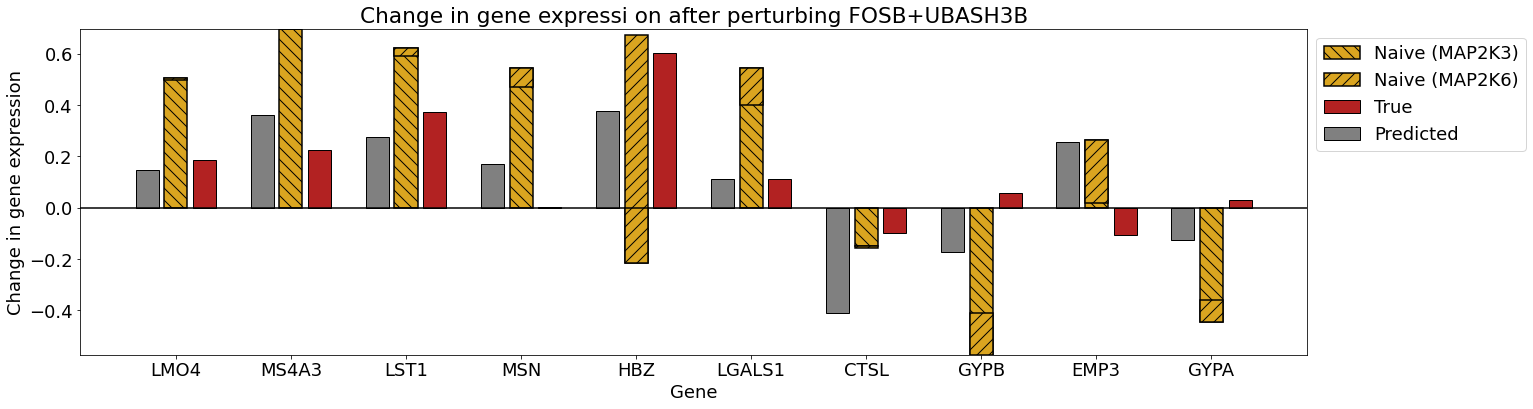

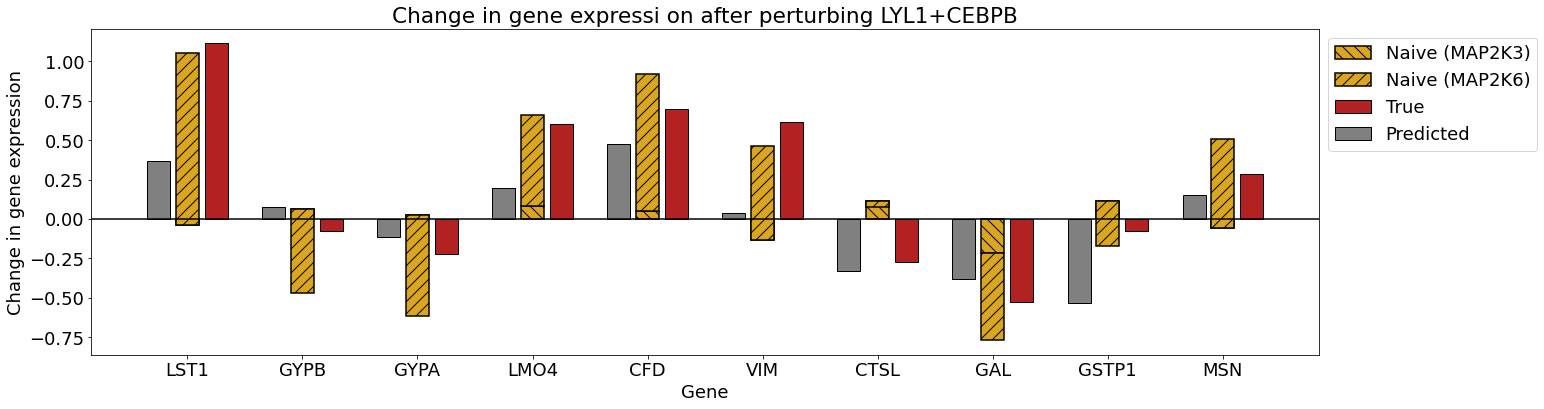

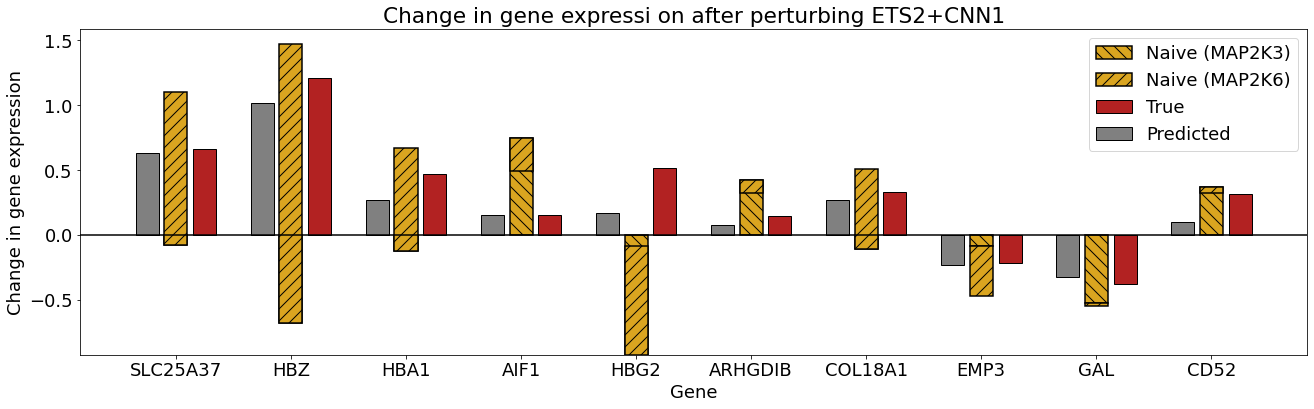

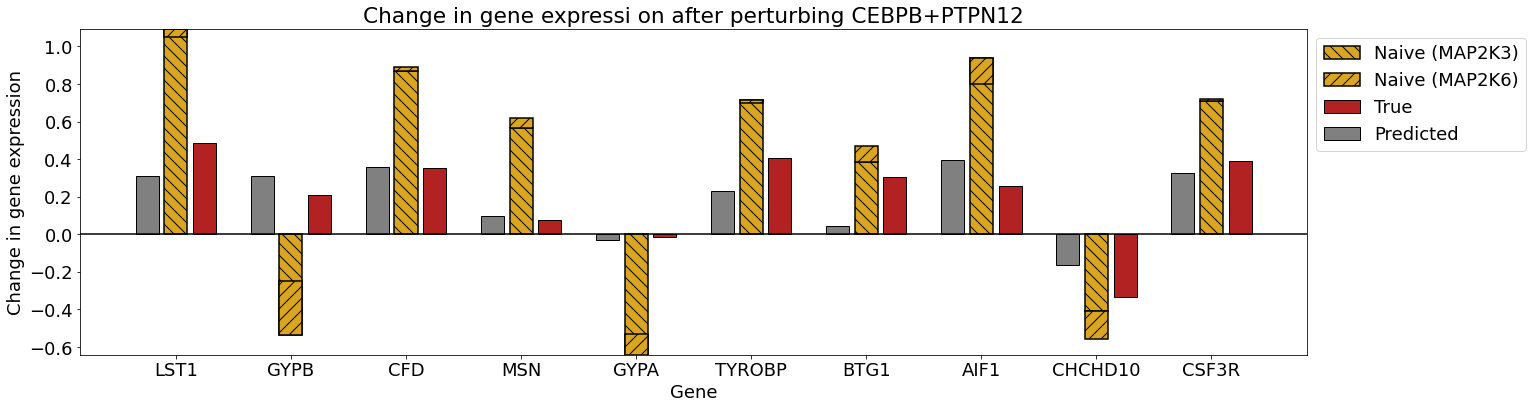

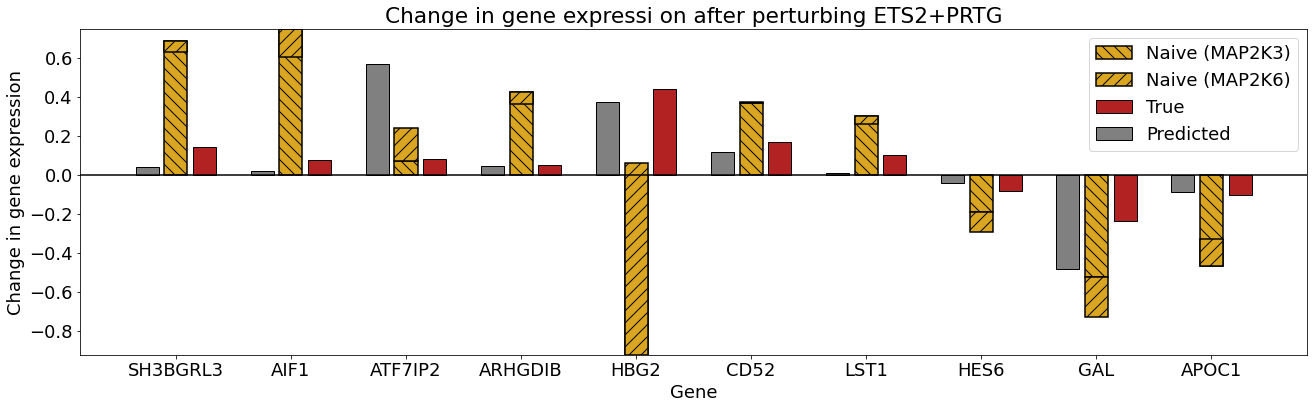

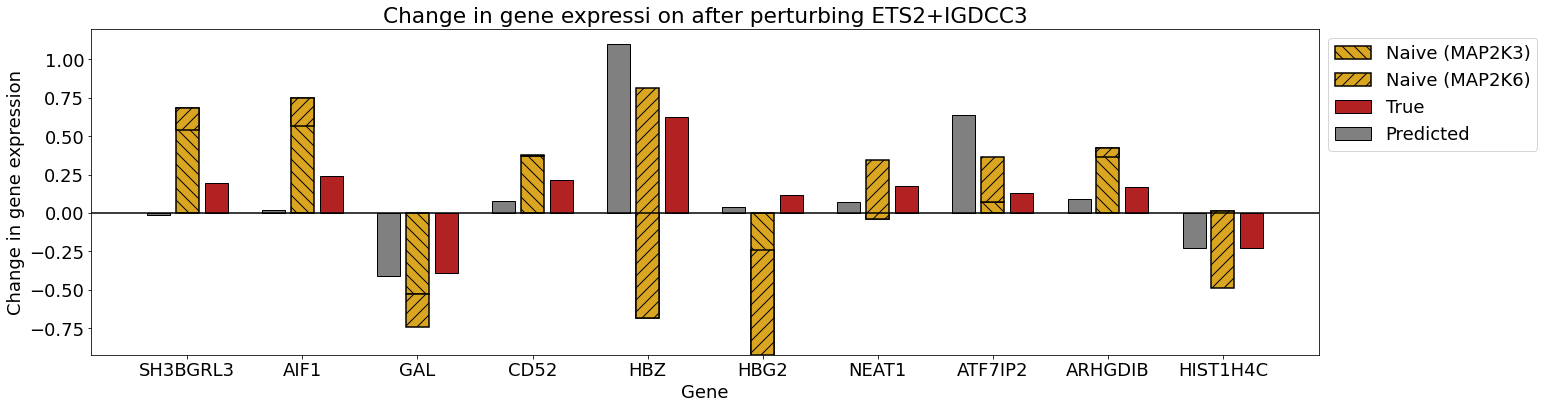

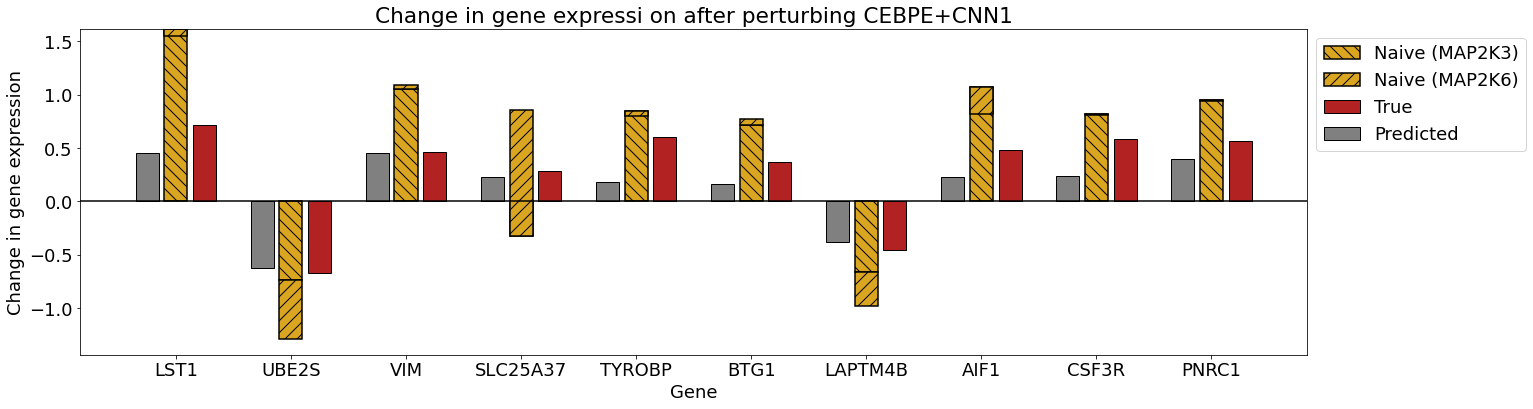

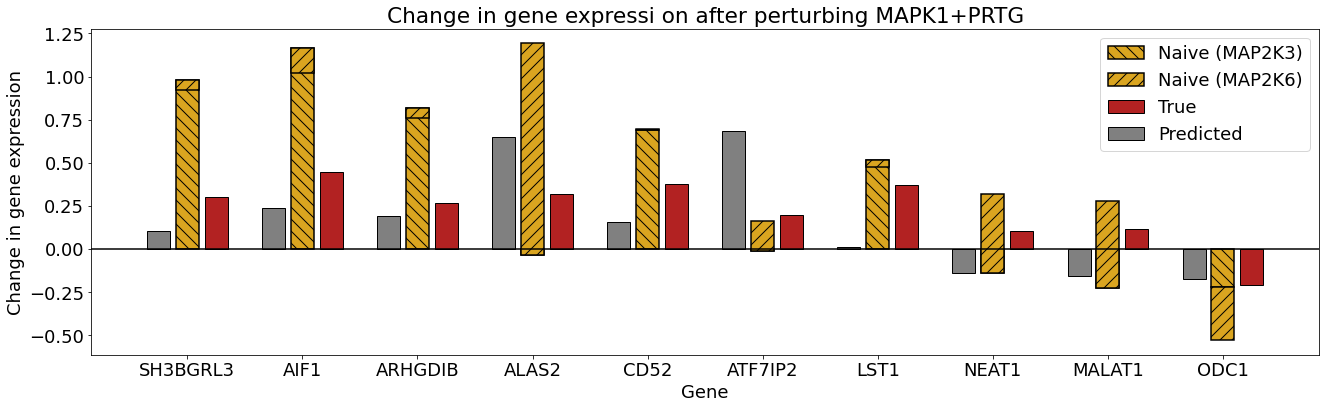

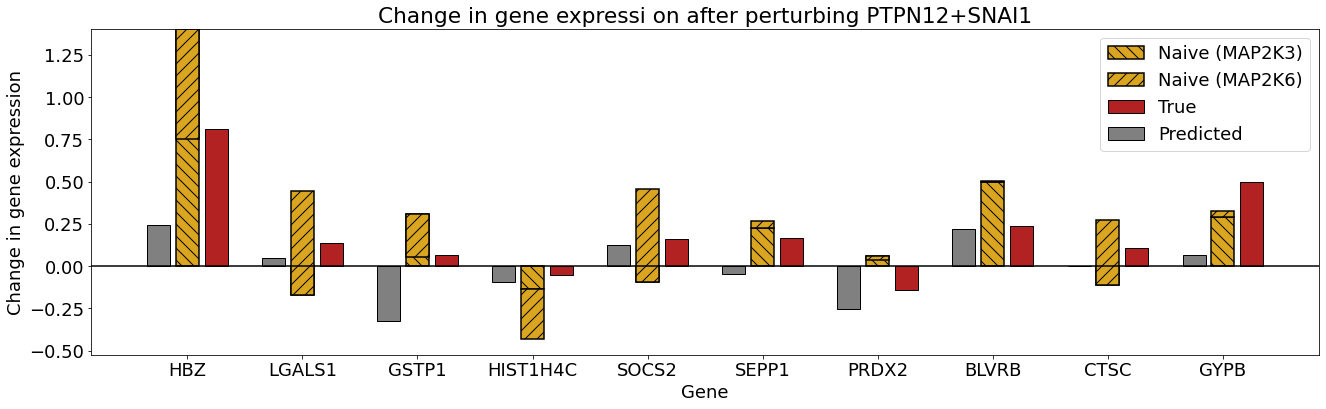

In [51]:
## Looking at all figures
for f in glob.glob('../GI_gene_mse/dfs/suppressor_crossgene_*'):
    plot_df = pd.read_csv(f, index_col=0)
    plot_df = plot_df.iloc[:,:10]
    
    fig = plt.figure(figsize=[22,6])
    ax = plt.gca()
    step = 4
    xticks = []
    xticklabels = []
    combo = f.split('crossgene_')[-1]

    for itr, gene in enumerate(plot_df.columns):
        add_bar_group(plot_df, (itr*step), combo, gene, ax)
        xticks.append(itr*step+1)
        xticklabels.append(gene)

    plt.legend(['Naive (MAP2K3)', 'Naive (MAP2K6)', 'True', 'Predicted'], bbox_to_anchor=(1.0, 1.0))
    plt.ylabel('Change in gene expression')
    #plt.ylim([-0.5, 1.2])
    plt.xlabel('Gene')
    plt.title('Change in gene expressi on after perturbing '+combo)

    plt.xticks(xticks, xticklabels)

    ax.axhline(y=0, color='k')

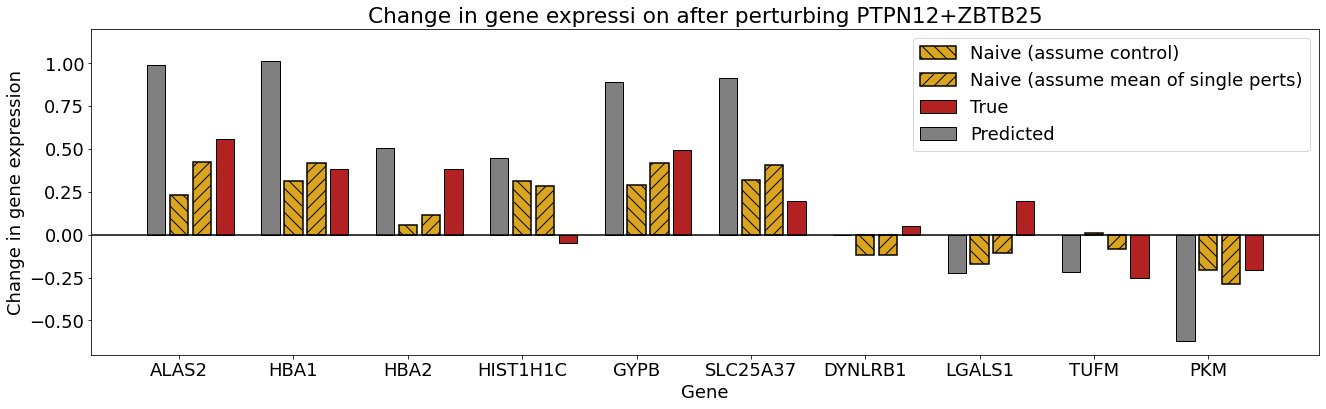

In [24]:
# # Seen 1
fig = plt.figure(figsize=[22,6])
ax = plt.gca()
step = 5
xticks = []
xticklabels = []
combo = 'PTPN12+ZBTB25'

for itr, gene in enumerate(plot_df.columns):
    add_bar_group(plot_df, (itr*step), combo, gene, ax, seen=1)
    xticks.append(itr*step+1)
    xticklabels.append(gene)

plt.legend(['Naive (assume control)', 'Naive (assume mean of single perts)', 'True', 'Predicted'], bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Change in gene expression')
plt.ylim([-0.7, 1.2])
plt.xlabel('Gene')
plt.title('Change in gene expressi on after perturbing '+combo)

plt.xticks(xticks, xticklabels)

ax.axhline(y=0, color='k')

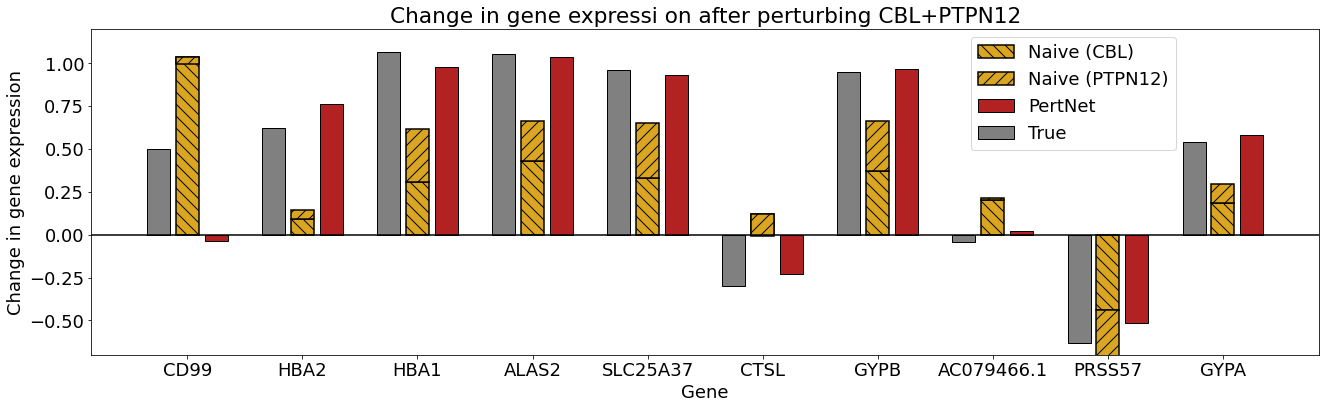

In [15]:
# # new code 
fig = plt.figure(figsize=[22,6])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
combo = 'CBL+PTPN12'

for itr, gene in enumerate(plot_df.columns):
    add_bar_group(plot_df, (itr*step), combo, gene, ax)
    xticks.append(itr*step+1)
    xticklabels.append(gene)

plt.legend(['Naive (CBL)', 'Naive (PTPN12)', 'PertNet', 'True'], bbox_to_anchor=(0.8, 0.6))
plt.ylabel('Change in gene expression')
plt.ylim([-0.7, 1.2])
plt.xlabel('Gene')
plt.title('Change in gene expressi on after perturbing '+combo)

plt.xticks(xticks, xticklabels)

ax.axhline(y=0, color='k')

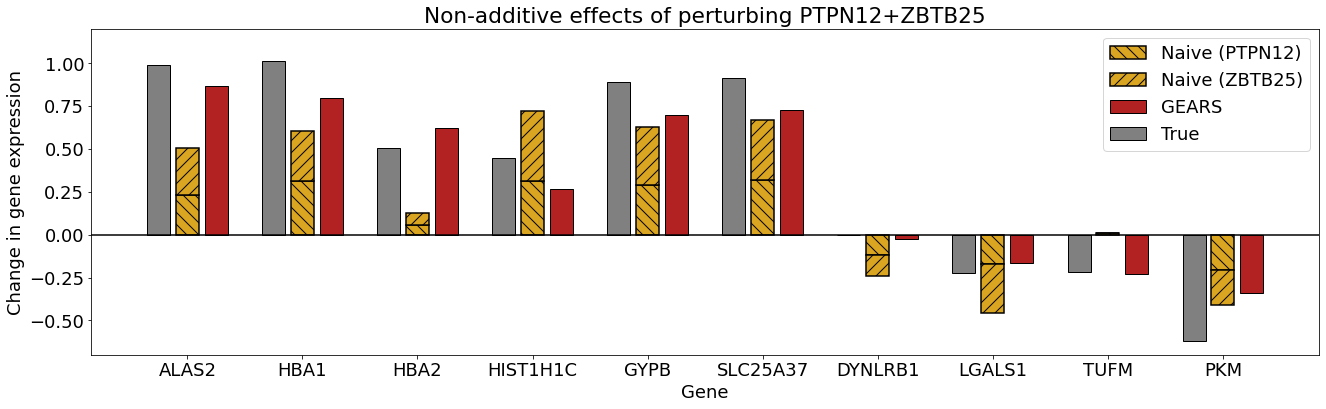

In [13]:
# # new code 
fig = plt.figure(figsize=[22,6])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
combo = 'PTPN12+ZBTB25'

for itr, gene in enumerate(plot_df.columns):
    add_bar_group(plot_df, (itr*step), combo, gene, ax)
    xticks.append(itr*step+1)
    xticklabels.append(gene)

plt.legend(['Naive (PTPN12)', 'Naive (ZBTB25)', 'GEARS', 'True'], bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Change in gene expression')
plt.ylim([-0.7, 1.2])
plt.xlabel('Gene')
plt.title('Non-additive effects of perturbing '+combo)

plt.xticks(xticks, xticklabels)

ax.axhline(y=0, color='k')